# Optimal resource allocation in microbial growth

<img src="maintenance.png" width=400>

[Thumbnail](maintenance.png)

Microorganisms must assign the resources available in the environment to different cellular functions. In nature, it is assumed that bacteria have evolved in a way that their resource allocation strategies maximize their biomass. Consider the simple resource allocation mathematical model

$$ \begin{array}{rcl}
\dot{p} &=& E_m m - (p+1) v_R(p,r), \\
\dot{r} &=& (\alpha r_{\max}-r) v_R(p,r), \\
\dot{m} &=& ((1-\alpha) r_{\max}-m) v_R(p,r),
\end{array} $$

where $p$, $r$, $m$ and $q$ are the mass fractions of: precursor metabolites, the gene expression machinery (ribosomes, RNA polymerase...), the metabolic machinery (enzymes, transporters...) and the housekeeping machinery respectively. The microbial growth rate is defined as $v_R(p,r) = \frac{p(r-r_{min})}{K+p}$. Constants $E_M$, $r_{max}$, $r_{min}$ and $K$ are positive. Maximizing the bacterial biomass is equivalent to maximizing the integral of the growth rate over a fixed time window $[0,T]$. Thus, the cost function of the optimal control problem can be written as

$$ J(\alpha) = \int_0^T v_R(p,r) \, \mathrm{d}t \to \max $$

with the resource allocation parameter (i.e. the control) constrained to $\alpha(t) \in [0,1]$.

A reduced (and idealised) model consists in taking $r \in (r_{\min},r_{\max})$ as the new control and restrict the states to $p$, $q$ and $V$. (Using $q=1-(r+m)$ instead of $m$ eliminates $\alpha$ from the dynamics of the remaining states.)

In [5]:
using JuMP, Ipopt

# JuMP model, Ipopt solver
foo1 = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 5))
# todo: r+m+q = 1 take r as new control (+ contrainst on m...) and replace m by q (no α in q')

# Parameters
Em = 0.6                   # Em 
K = 0.003                  # K
rmin = 0.07                # rmin
rmax = 0.5                 # rmax
t0 = 0.0                   # initial time
tf = 20.0                  # final time
p0 = 0.03                  # p0
r0 = 0.1                   # r0
m0 = 0.2                   # m0
V0 = 0.003                 # V0
q0 = 1.0-(r0+m0)           # r+q+m = 1
N = 2000                   # grid size
Δt = (tf-t0)/N             # Time step

@variables(foo1, begin
    0. ≤ p[1:N] ≤ 1.       # p 
    rmin ≤ r[1:N] ≤ rmax   # r
    0. ≤ m[1:N] ≤ 1.       # m
    0. ≤ V[1:N]            # V
    0. ≤ α[1:N] ≤ 1.       # allocation (control)
end)

# Objective
@objective(foo1, Max, V[N])

# Initial conditions
@constraints(foo1, begin
    p[1] == p0
    r[1] == r0
    m[1] == m0
    V[1] == V0
end)

# Dynamics, Crank-Nicolson scheme

@NLexpression(foo1, vR[j = 1:N], (r[j]-rmin)*p[j]/(K+p[j]))

for j in 1:N-1
    @NLconstraint(foo1, # p' = Em*m - (p+1)*vR
        p[j+1] == p[j] + 0.5 * Δt * ( Em*m[j]-(p[j]+1)*vR[j] + Em*m[j+1]-(p[j+1]+1)*vR[j+1] ))
    @NLconstraint(foo1, # r' = (α*rmax-r)*vR
        r[j+1] == r[j] + 0.5 * Δt * ( (α[j]*rmax-r[j])*vR[j] + (α[j+1]*rmax-r[j+1])*vR[j+1] )) 
    @NLconstraint(foo1, # m' = ((1-α)*rmax-m)*vR
        m[j+1] == m[j] + 0.5 * Δt * ( ((1-α[j])*rmax-m[j])*vR[j] + ((1-α[j+1])*rmax-m[j+1])*vR[j+1] )) 
    @NLconstraint(foo1, # v' = vR*V
        V[j+1] == V[j] + 0.5 * Δt * ( vR[j]*V[j] + vR[j+1]*V[j+1] ))
end

# Solve for the control and state
println("Solving...")
status = optimize!(foo1)
println("Solver status: ", status)
p1 = value.(p)
r1 = value.(r)
m1 = value.(m)
V1 = value.(V)
α = value.(α)
println("Cost: ", objective_value(foo1))

Solving...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    51978
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    99950

Total number of variables............................:    10000
                     variables with only lower bounds:     2000
                variables with lower and upper bounds:     8000
                     variables with only upper bounds:        0
Total number of equality constraints.................:     8000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

In [6]:
using JuMP, Ipopt

# JuMP model, Ipopt solver
foo2 = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 5))

@variables(foo2, begin
    0. ≤ p[1:N] ≤ 1.       # p 
    0. ≤ q[1:N] ≤ 1.       # q
    0. ≤ V[1:N]            # V
    rmin ≤ r[1:N] ≤ rmax   # r (new control)
end)

# Objective
@objective(foo2, Max, V[N])

# Initial conditions
@constraints(foo2, begin
    p[1] == p0
    q[1] == 1-(r0+m0)
    V[1] == V0
end)

# Dynamics, Crank-Nicolson scheme

@NLexpression(foo2, vR[j = 1:N], (r[j]-rmin)*p[j]/(K+p[j]))
@NLexpression(foo2, m[j = 1:N], 1-r[j]-q[j])


for j in 1:N-1
    @NLconstraint(foo2, # p' = Em*m - (p+1)*vR
        p[j+1] == p[j] + 0.5 * Δt * ( Em*m[j]-(p[j]+1)*vR[j] + Em*m[j+1]-(p[j+1]+1)*vR[j+1] ))
    @NLconstraint(foo2, # m' = ((1-α)*rmax-m)*vR
        q[j+1] == q[j] + 0.5 * Δt * ( (1-q[j]-rmax)*vR[j] + (1-q[j+1]-rmax)*vR[j+1] )) 
    @NLconstraint(foo2, # v' = vR*V
        V[j+1] == V[j] + 0.5 * Δt * ( vR[j]*V[j] + vR[j+1]*V[j+1] ))
end

# Solve for the control and state
println("Solving...")
status = optimize!(foo2)
println("Solver status: ", status)
println("Cost: ", objective_value(foo2))
p2 = value.(p)
q2 = value.(q)
V2 = value.(V)
r2 = value.(r)
m2 = 1 .- (q2+r2);

Solving...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    35985
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    59970

Total number of variables............................:     8000
                     variables with only lower bounds:     2000
                variables with lower and upper bounds:     6000
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr

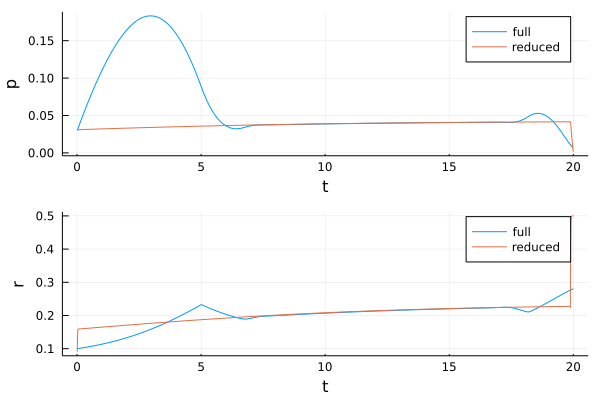

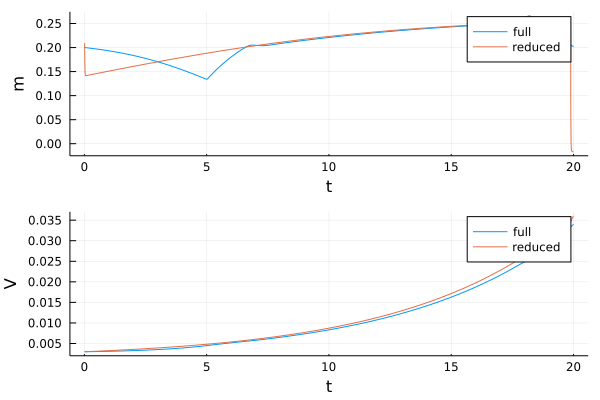

LoadError: IOError: unlink("C:\\Users\\BAPTISTE\\AppData\\Local\\Temp\\jl_em0WVroQyQ.svg"): resource busy or locked (EBUSY)

In [7]:
# Plots
using Plots
t = (1:N) * Δt
p_plot = plot(t, p1, xlabel = "t", ylabel = "p", label = "full"); plot!(p_plot, t, p2, label = "reduced")
r_plot = plot(t, r1, xlabel = "t", ylabel = "r", label = "full"); plot!(r_plot, t, r2, label = "reduced")
m_plot = plot(t, m1, xlabel = "t", ylabel = "m", label = "full"); plot!(m_plot, t, m2, label = "reduced")
V_plot = plot(t, V1, xlabel = "t", ylabel = "V", label = "full"); plot!(V_plot, t, V2, label = "reduced")
α_plot = plot(t,  α, xlabel = "t", ylabel = "α", label = "full")
display(plot(p_plot, r_plot, layout = (2, 1) ))
display(plot(m_plot, V_plot, layout = (2, 1)))
display(plot(α_plot))